#### **Task**: Image Classifications of Insects (Beetles, Cockroaches, Dragonflies) 
#### **Method**: Transfer Learning using InceptionV3 and VGG16
#### **Tools**: Tensorflow.keras 
#### **Data Source**: [Insectimages](https://www.insectimages.org/index.cfm)

In [44]:
%matplotlib inline

In [45]:
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

In [29]:
# import packages 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import cv2

#tensorflow packages 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model


In [30]:
import random 
#set random seed for replication 
np.random.seed(0)
tf.random.set_seed(0)


References: https://www.youtube.com/watch?v=j-3vuBynnOE

# Data Preprocessing 

In [31]:
#save current directory 
cd = os.getcwd()

In [32]:
TRAIN_DIR = os.path.join(cd, 'Data_insects/train') #directory for training data 
TEST_DIR = os.path.join(cd, 'Data_insects/test') # directory for test data 
CLASSES = ['beetles', 'cockroach', 'dragonflies'] 

In [33]:
#set image size 
IMG_SIZE = 224

### Train data with labels 

In [34]:
train_data = []
def create_train_data():
    for cl in CLASSES: 
        path = os.path.join(TRAIN_DIR, cl) #path to train data 
        for img in os.listdir(path): 
            try: 
                cl_label = CLASSES.index(cl) #assigns label to the images
                img_data = cv2.imread(os.path.join(path, img)) #read image 
                img_data.shape
                new_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE)) #resize image 
                train_data.append([new_data, cl_label])
            except Exception as e:
                pass
create_train_data()

In [35]:
#shuffle the data 
random.shuffle(train_data)

In [36]:
print(f'There are {len(train_data)} images in training data.')

There are 1019 images in training data.


In [37]:
#save train data and its labels 
X_train = []
y_train = []

for feature, lb in train_data:
    X_train.append(feature)
    y_train.append(lb)

### Test data with labels 

In [38]:
test_data = []
def create_test_data():
    for cl in CLASSES: 
        path = os.path.join(TEST_DIR, cl) #path to test data 
        for img in os.listdir(path): 
            try: 
                cl_label = CLASSES.index(cl)
                img_data = cv2.imread(os.path.join(path, img))
                new_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
                test_data.append([new_data, cl_label])
            except Exception as e:
                pass
create_test_data()

In [39]:
#save test data and its labels 
X_test = []
y_test = []
    
for feature, lb in test_data:
    X_test.append(feature)
    y_test.append(lb)

In [40]:
#reshape train and test data 
X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

#normalize 
X_train = X_train/225.0
X_test = X_test/225.0

In [41]:
X_train.shape

(1019, 224, 224, 3)

### Sample Data (Beetles, Cockroaches, and Dragonflies)

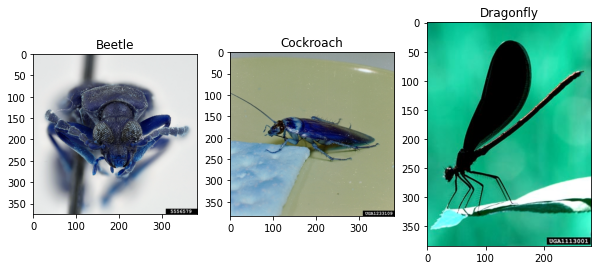

In [42]:
beetle = cv2.imread(os.path.join(TRAIN_DIR, 'beetles/5556579.jpg'))
cockroach = cv2.imread(os.path.join(TRAIN_DIR, 'cockroach/1233109.jpg'))
dragonfly = cv2.imread(os.path.join(TRAIN_DIR, 'dragonflies/1113001.jpg'))

fig = plt.figure(figsize = (10, 15))
fig.add_subplot(1, 3, 1)
plt.title('Beetle')
plt.imshow(beetle)
fig.add_subplot(1, 3, 2)
plt.title('Cockroach')
plt.imshow(cockroach)
fig.add_subplot(1, 3, 3)
plt.title('Dragonfly')
plt.imshow(dragonfly)
pass

# Deep Learning Models
## CNN (Sequential)

In [46]:
model = tf.keras.Sequential()

model.add(Conv2D(128, (4,4), input_shape = X_train.shape[1:])) #(3,3) window
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3))) #(3,3) window
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3))) #(3,3) window
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(3))
model.add(Activation('softmax'))
          
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hist = model.fit(X_train, y_train, batch_size = 64, epochs = 2, validation_split = 0.1, verbose = 0)

### Model Evaluation (based on accuracy)

In [47]:
test_loss_ml, test_acc_ml = model.evaluate(X_test, y_test)
test_acc_ml

180/180 [==============================] - 4s 20ms/sample - loss: 0.8433 - accuracy: 0.5944


0.59444445

# Transfer Learning using InceptionV3

In [56]:
base_model = InceptionV3(
    input_shape=X_train.shape[1:],
    weights='imagenet', #
    include_top=False,
    classes=3 # three classes for our problem 
)

In [57]:
for layer in base_model.layers:
    layer.trainable = False

In [58]:
x = Flatten()(base_model.output)
output = Dense(3, activation='softmax')(x)
inc_model = Model(inputs=base_model.input, outputs=output)

In [59]:
inc_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [60]:
inc_hist = inc_model.fit(X_train, y_train, batch_size = 64, epochs = 4, validation_split = 0.1)

Train on 917 samples, validate on 102 samples
Epoch 1/4
917/917 [==============================] - 34s 38ms/sample - loss: 5.0839 - accuracy: 0.5649 - val_loss: 5.6896 - val_accuracy: 0.6176
Epoch 2/4
917/917 [==============================] - 28s 30ms/sample - loss: 3.8723 - accuracy: 0.7274 - val_loss: 5.3099 - val_accuracy: 0.6667
Epoch 3/4
917/917 [==============================] - 38s 42ms/sample - loss: 3.6783 - accuracy: 0.7644 - val_loss: 5.3794 - val_accuracy: 0.6569
Epoch 4/4
917/917 [==============================] - 36s 40ms/sample - loss: 3.6531 - accuracy: 0.7699 - val_loss: 5.3289 - val_accuracy: 0.6569


In [61]:
test_loss_inc, test_acc_inc = inc_model.evaluate(X_test, y_test)
test_acc_inc

180/180 [==============================] - 9s 48ms/sample - loss: 5.6534 - accuracy: 0.6444


0.64444447

In [62]:
# fig, axes = plt.subplots(1,2,figsize=(12, 4))
# for ax, measure in zip(axes, ['loss', 'accuracy']):
#     ax.plot(inc_hist.history[measure], label=measure)
#     ax.plot(inc_hist.history['val_' + measure], label='val_' + measure)
#     ax.legend()
# pass

# Transfer Learning using VGG16 

In [64]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [65]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [66]:
vgg = VGG16(
    input_shape=X_train.shape[1:],
    weights='imagenet', 
    include_top=False,
    classes=3
)

In [67]:
for layer in vgg.layers:
    layer.trainable = False

In [68]:
x = Flatten()(vgg.output)
output = Dense(3, activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=output)

In [69]:
vgg_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [70]:
vgg_hist = vgg_model.fit(X_train, y_train, batch_size = 64, epochs = 4, validation_split = 0.1)

Train on 917 samples, validate on 102 samples
Epoch 1/4
917/917 [==============================] - 121s 132ms/sample - loss: 0.9465 - accuracy: 0.6772 - val_loss: 0.4247 - val_accuracy: 0.8431
Epoch 2/4
917/917 [==============================] - 115s 125ms/sample - loss: 0.2660 - accuracy: 0.9084 - val_loss: 0.2955 - val_accuracy: 0.9216
Epoch 3/4
917/917 [==============================] - 117s 128ms/sample - loss: 0.1397 - accuracy: 0.9487 - val_loss: 0.3021 - val_accuracy: 0.8725
Epoch 4/4
917/917 [==============================] - 116s 126ms/sample - loss: 0.0581 - accuracy: 0.9793 - val_loss: 0.2355 - val_accuracy: 0.9216


In [71]:
test_loss_vgg, test_acc_vgg = vgg_model.evaluate(X_test, y_test)
test_acc_vgg

180/180 [==============================] - 21s 116ms/sample - loss: 0.0782 - accuracy: 0.9778


0.9777778

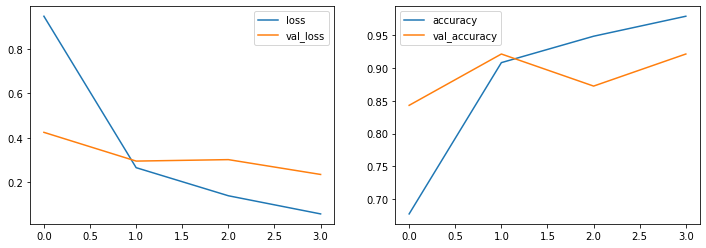

In [73]:
fig, axes = plt.subplots(1,2,figsize=(12, 4))
for ax, measure in zip(axes, ['loss', 'accuracy']):
    ax.plot(vgg_hist.history[measure], label=measure)
    ax.plot(vgg_hist.history['val_' + measure], label='val_' + measure)
    ax.legend()
pass

In [75]:
pred= vgg_model.predict(X_test)
np.argmax(pred,axis=1) # predicted classes 

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

Misclassified ids are 7, 10, 17, 102 which were supposed to be class 0 (beetle) but were classifies as cockroaches (4 and 7) and dragonfly (17).   

### Misclassified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


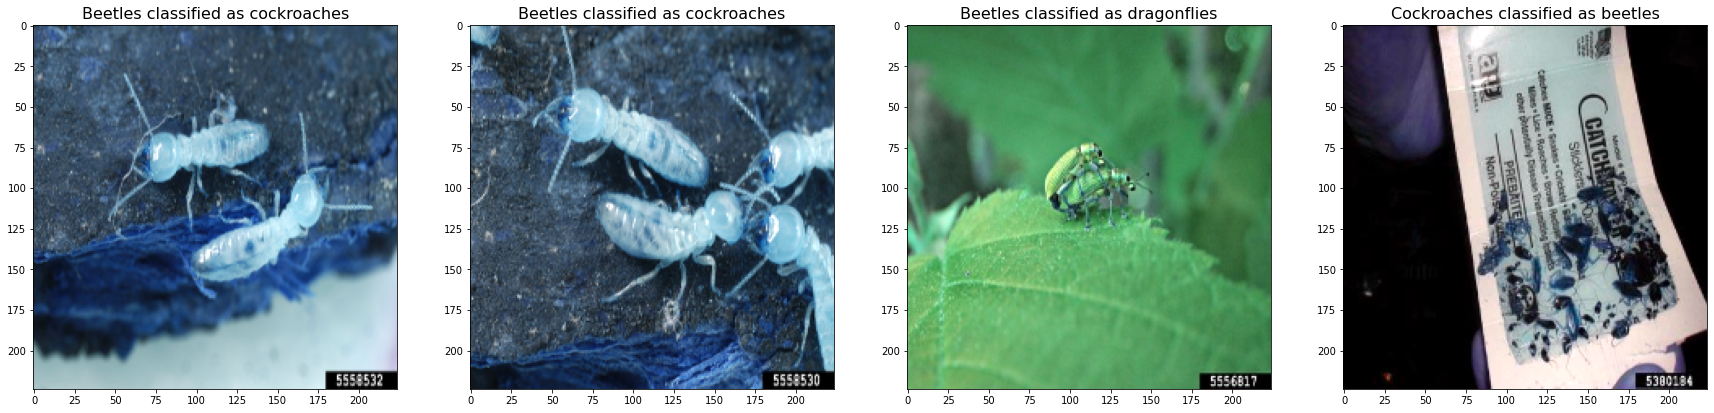

In [83]:
fig = plt.figure(figsize = (30, 15))
fig.add_subplot(1, 4, 1)
plt.title('Beetles classified as cockroaches', fontsize=16)
plt.imshow(X_test[7,:,:,:]);
fig.add_subplot(1, 4, 2)
plt.title('Beetles classified as cockroaches', fontsize=16)
plt.imshow(X_test[10,:,:,:]);
fig.add_subplot(1, 4, 3)
plt.title('Beetles classified as dragonflies', fontsize=16)
plt.imshow(X_test[17,:,:,:]);
fig.add_subplot(1, 4, 4)
plt.title('Cockroaches classified as beetles', fontsize=16)
plt.imshow(X_test[102,:,:,:]);

Looking at the images, it is not surprizing that CNN could not classify these images correcly. 

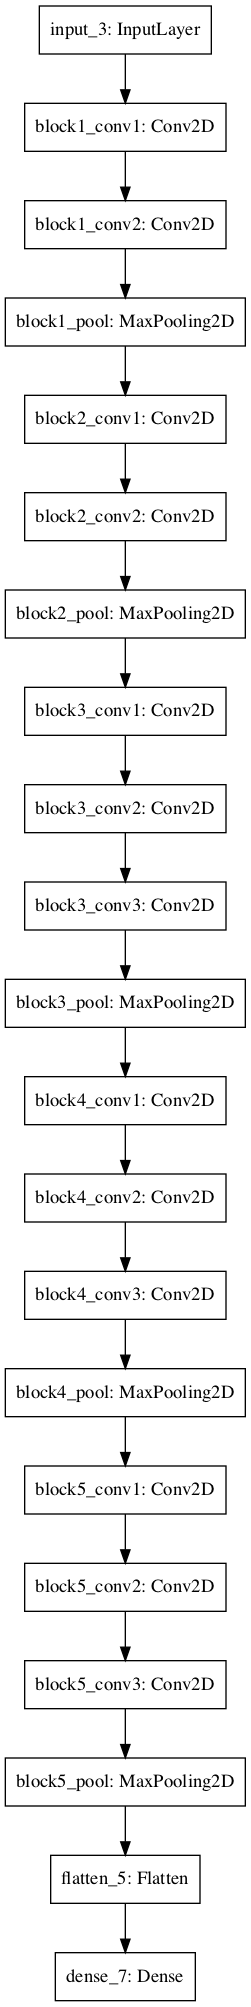

In [84]:
plot_model(vgg_model)

In [92]:
import shap

In [99]:
explainer = shap.GradientExplainer(vgg_model, X_train)

In [100]:
sv = explainer.shap_values(X_test[:5]);

In [101]:
vgg_model.predict(X_test[:5])

array([[9.79833782e-01, 9.35671665e-03, 1.08095678e-02],
       [9.76368666e-01, 2.35209819e-02, 1.10389796e-04],
       [9.91904318e-01, 6.79412950e-03, 1.30165124e-03],
       [9.99519825e-01, 4.79937851e-04, 2.20225701e-07],
       [9.29574966e-01, 5.15427403e-02, 1.88822374e-02]], dtype=float32)

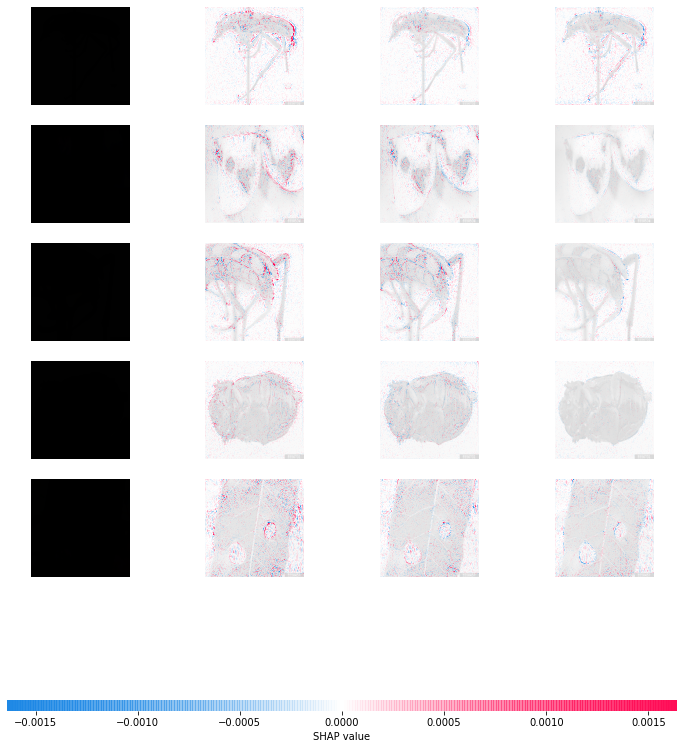

In [102]:
shap.image_plot([sv[i] for i in range(3)], X_test[:5])

Helpful features for predictions are in red and features which worsen predictions are in blue. 